<a href="https://colab.research.google.com/github/anko00/MachineLearning/blob/main/Week_5_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PCA example with Iris Data-set**

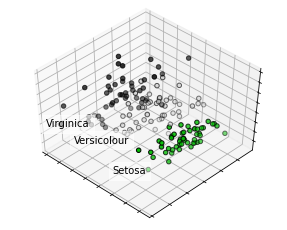

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

# **Comparison of LDA and PCA 2D projection of Iris dataset**

Automatically created module for IPython interactive environment
explained variance ratio (first two components): [0.92461872 0.05306648]


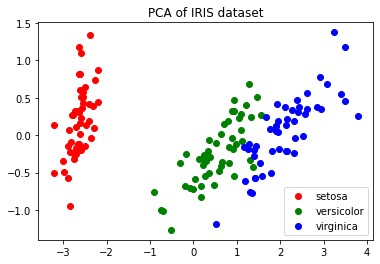

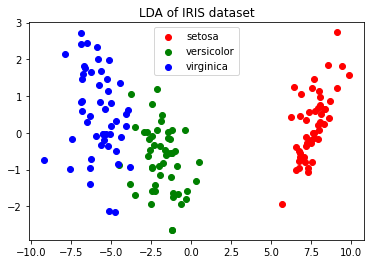

In [5]:
print(__doc__)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of IRIS dataset')


#LDA calculation
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)


# Percentage of variance explained for each components
plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of IRIS dataset')

plt.show()

# **Clustering using k-means**

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# parse commandline arguments
op = OptionParser()
op.add_option(
    "--lsa",
    dest="n_components",
    type="int",
    help="Preprocess documents with latent semantic analysis.",
)
op.add_option(
    "--no-minibatch",
    action="store_false",
    dest="minibatch",
    default=True,
    help="Use ordinary k-means algorithm (in batch mode).",
)
op.add_option(
    "--no-idf",
    action="store_false",
    dest="use_idf",
    default=True,
    help="Disable Inverse Document Frequency feature weighting.",
)
op.add_option(
    "--use-hashing",
    action="store_true",
    default=False,
    help="Use a hashing feature vectorizer",
)
op.add_option(
    "--n-features",
    type=int,
    default=10000,
    help="Maximum number of features (dimensions) to extract from text.",
)
op.add_option(
    "--verbose",
    action="store_true",
    dest="verbose",
    default=False,
    help="Print progress reports inside k-means algorithm.",
)

print(__doc__)
op.print_help()
print()


def is_interactive():
    return not hasattr(sys.modules["__main__"], "__file__")


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(
    subset="all", categories=categories, shuffle=True, random_state=42
)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm=None,
        )
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm="l2",
        )
else:
    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=opts.n_features,
        min_df=2,
        stop_words="english",
        use_idf=opts.use_idf,
    )
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(
        n_clusters=true_k,
        init="k-means++",
        n_init=1,
        init_size=1000,
        batch_size=1000,
        verbose=opts.verbose,
    )
else:
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=100,
        n_init=1,
        verbose=opts.verbose,
    )

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_, sample_size=1000)
)

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end="")
        for ind in order_centroids[i, :10]:
            print(" %s" % terms[ind], end="")
        print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 1.009186s
n_samples: 3387, n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute

# **Iris Dataset Visualization**

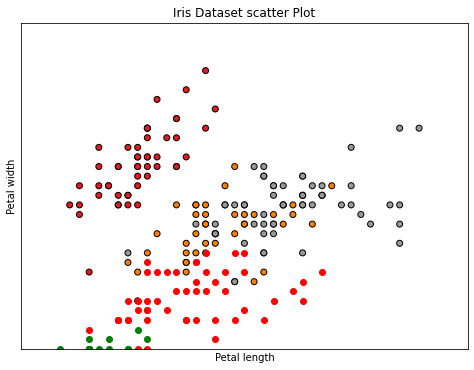

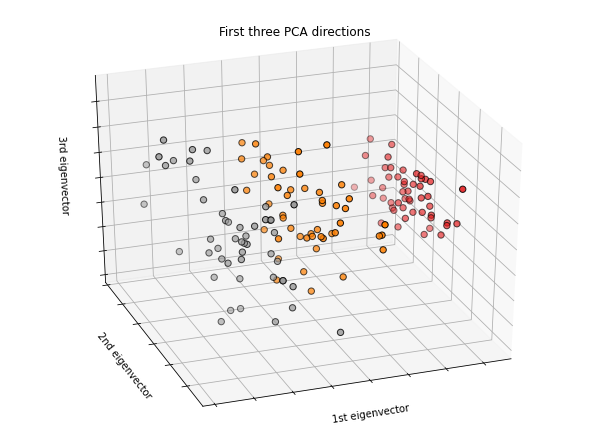

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA


# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())


# show petals in different ways
# https://www.kaggle.com/lalitharajesh/iris-dataset-exploratory-data-analysis

featuresAll=[]
features = iris.data[: , [0,1,2,3]]
features.shape

#Finding the relationship between Petal Length and Petal width
featuresAll = []
targets = []
for feature in features:
    featuresAll.append(feature[2]) #Petal length
    targets.append(feature[3]) #Petal width

groups = ('Iris-setosa','Iris-versicolor','Iris-virginica')
colors = ('blue', 'green','red')
data = ((featuresAll[:50], targets[:50]), (featuresAll[50:100], targets[50:100]), 
        (featuresAll[100:150], targets[100:150]))

for item, color, group in zip(data,colors,groups): 
    #item = (featuresAll[:50], targets[:50]), (featuresAll[50:100], targets[50:100]), (featuresAll[100:150], targets[100:150])
    x0, y0 = item
    plt.scatter(x0, y0,color=color,alpha=1)
    plt.title('Iris Dataset scatter Plot')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# **PCA MNIST**

In [10]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [11]:
mnist

{'DESCR': "**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered i

In [12]:
# These are the images
mnist.data.shape

(70000, 784)

In [13]:
# These are the labels
mnist.target.shape

(70000,)

In [14]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_img, test_img, train_lbl, test_lbl = train_test_split( mnist.data, mnist.target, test_size=1/7.0, random_state=0)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_img)
# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

In [16]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

In [17]:
lower_dimensional_data = pca.fit_transform(mnist.data)

In [18]:
pca.n_components_

154

In [19]:
approximation = pca.inverse_transform(lower_dimensional_data)

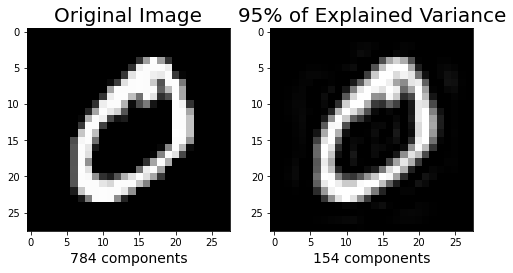

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(mnist.data[1].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[1].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('154 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

In [21]:
# if n_components is not set all components are kept (784 in this case)
pca = PCA()

In [22]:
pca.fit(mnist.data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:
pca.n_components_

784

In [24]:
# Summing explained variance
tot = sum(pca.explained_variance_)
tot

3430023.4480794817

In [25]:
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])

[9.746115922494745, 7.155444586878719, 6.149530980723048, 5.40338452854818, 4.888933703877896]


In [26]:
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])

[9.746115922494745, 7.155444586878719, 6.149530980723048, 5.40338452854818, 4.888933703877896]


In [27]:
tot = sum(pca.explained_variance_)
tot

3430023.4480794817

In [28]:
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])

[9.746115922494745, 7.155444586878719, 6.149530980723048, 5.40338452854818, 4.888933703877896]


In [29]:
# Cumulative explained variance
import numpy as np
cum_var_exp = np.cumsum(var_exp)

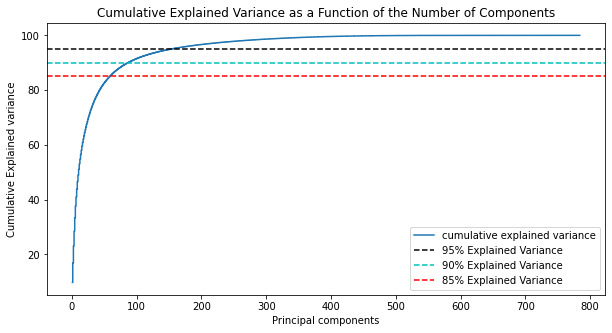

In [30]:
#PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.step(range(1, 785), cum_var_exp, where='mid',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 85, color='r', linestyle='--', label = '85% Explained Variance')
plt.legend(loc='best')
plt.show()

In [31]:

# Indices corresponding to the first occurrence are returned with the np.argmax function
# Adding 1 to the end of value in list as principal components start from 1 and indexes start from 0 (np.argmax)
componentsVariance = [784, np.argmax(cum_var_exp > 99) + 1, np.argmax(cum_var_exp > 95) + 1, np.argmax(cum_var_exp > 90) + 1, np.argmax(cum_var_exp >= 85) + 1]

In [32]:
componentsVariance

[784, 331, 154, 87, 59]

In [33]:
from sklearn.decomposition import PCA

# This is an extremely inefficient function. Will get to why in a later tutorial
def explainedVariance(percentage, images): 
    # percentage should be a decimal from 0 to 1 
    pca = PCA(percentage)
    pca.fit(images)
    components = pca.transform(images)
    approxOriginal = pca.inverse_transform(components)
    return approxOriginal

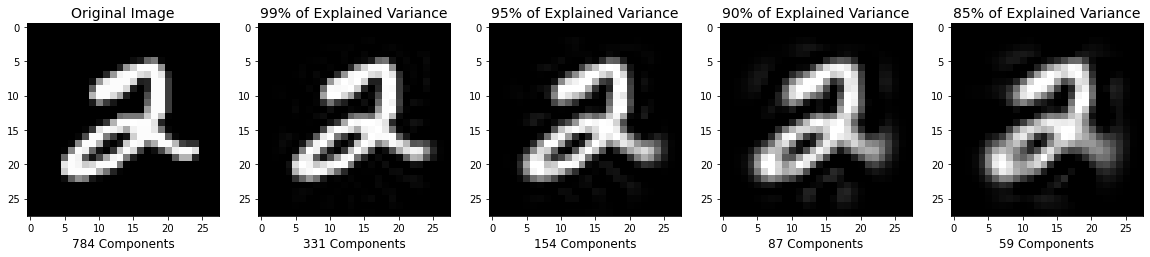

In [34]:
plt.figure(figsize=(20,4));

# Original Image (784 components)
plt.subplot(1, 5, 1);
plt.imshow(mnist.data[5].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 Components', fontsize = 12)
plt.title('Original Image', fontsize = 14);

# 331 principal components
plt.subplot(1, 5, 2);
plt.imshow(explainedVariance(.99, mnist.data)[5].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('331 Components', fontsize = 12)
plt.title('99% of Explained Variance', fontsize = 14);

# 154 principal components
plt.subplot(1, 5, 3);
plt.imshow(explainedVariance(.95, mnist.data)[5].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('154 Components', fontsize = 12)
plt.title('95% of Explained Variance', fontsize = 14);

# 87 principal components
plt.subplot(1, 5, 4);
plt.imshow(explainedVariance(.90, mnist.data)[5].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('87 Components', fontsize = 12)
plt.title('90% of Explained Variance', fontsize = 14);

# 59 principal components
plt.subplot(1, 5, 5);
plt.imshow(explainedVariance(.85, mnist.data)[5].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('59 Components', fontsize = 12)
plt.title('85% of Explained Variance', fontsize = 14);

# **PCA Dataviz**

In [35]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [36]:
#see the table
df

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [37]:
#standarisasi fitur
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [38]:
Standardizing = pd.DataFrame(data = x, columns = ['sepal length','sepal width','petal length','petal width'])

In [39]:
Standardizing

,sepal length,sepal width,petal length,petal width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977
...,...,...,...,...
145,1.038005,-0.124958,0.819624,1.447956
146,0.553333,-1.281972,0.705893,0.922064
147,0.795669,-0.124958,0.819624,1.053537
148,0.432165,0.800654,0.933356,1.447956


In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [41]:
principalDf

,principal component 1,principal component 2
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767
...,...,...
145,1.870522,0.382822
146,1.558492,-0.905314
147,1.520845,0.266795
148,1.376391,1.016362


In [42]:
#Concatenating dataframes along columns to make finalDf before plotting the data.
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

In [43]:
df[['target']]

,target
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [44]:
finalDf

,principal component 1,principal component 2,target
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa
3,-2.304197,-0.575368,Iris-setosa
4,-2.388777,0.674767,Iris-setosa
...,...,...,...
145,1.870522,0.382822,Iris-virginica
146,1.558492,-0.905314,Iris-virginica
147,1.520845,0.266795,Iris-virginica
148,1.376391,1.016362,Iris-virginica


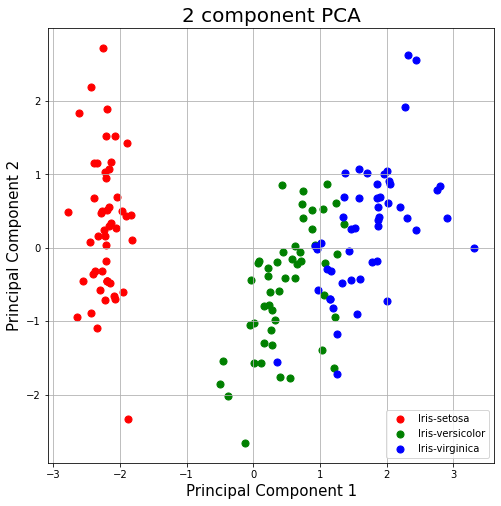

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [46]:
#total 95.80% of the information
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

# **PCA Feature Scaling**

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline

# Code source: Tyler Lanigan <tylerlanigan@gmail.com>
#              Sebastian Raschka <mail@sebastianraschka.com>

# License: BSD 3 clause

In [48]:
RANDOM_STATE = 42
FIG_SIZE = (10, 7)

In [49]:
features, target = load_wine(return_X_y=True)

In [50]:
# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.30, random_state=RANDOM_STATE
)

In [51]:
# Fit to data and predict using pipelined GNB and PCA.
unscaled_clf = make_pipeline(PCA(n_components=2), GaussianNB())
unscaled_clf.fit(X_train, y_train)
pred_test = unscaled_clf.predict(X_test)

In [52]:
# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

In [53]:
# Show prediction accuracies in scaled and unscaled data.
print("\nPrediction accuracy for the normal test dataset with PCA")
print("{:.2%}\n".format(metrics.accuracy_score(y_test, pred_test)))


Prediction accuracy for the normal test dataset with PCA
81.48%



In [54]:
print("\nPrediction accuracy for the standardized test dataset with PCA")
print("{:.2%}\n".format(metrics.accuracy_score(y_test, pred_test_std)))


Prediction accuracy for the standardized test dataset with PCA
98.15%



In [55]:
# Extract PCA from pipeline
pca = unscaled_clf.named_steps["pca"]
pca_std = std_clf.named_steps["pca"]

In [56]:
# Show first principal components
print("\nPC 1 without scaling:\n", pca.components_[0])
print("\nPC 1 with scaling:\n", pca_std.components_[0])


PC 1 without scaling:
 [ 1.76342917e-03 -8.35544737e-04  1.54623496e-04 -5.31136096e-03
  2.01663336e-02  1.02440667e-03  1.53155502e-03 -1.11663562e-04
  6.31071580e-04  2.32645551e-03  1.53606718e-04  7.43176482e-04
  9.99775716e-01]

PC 1 with scaling:
 [ 0.13443023 -0.25680248 -0.0113463  -0.23405337  0.15840049  0.39194918
  0.41607649 -0.27871336  0.33129255 -0.11383282  0.29726413  0.38054255
  0.27507157]


In [58]:
# Use PCA without and with scale on X_train data for visualization.
X_train_transformed = pca.transform(X_train)
scaler = std_clf.named_steps["standardscaler"]
X_train_std_transformed = pca_std.transform(scaler.transform(X_train))

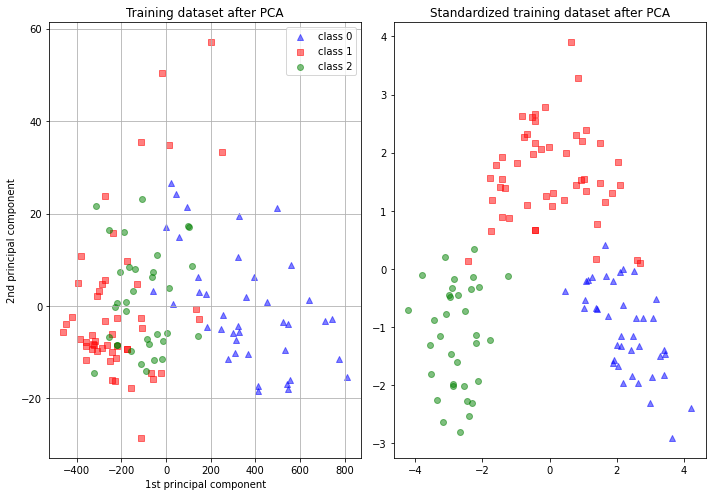

<Figure size 432x288 with 0 Axes>

In [59]:
# visualize standardized vs. untouched dataset with PCA performed
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=FIG_SIZE)
for l, c, m in zip(range(0, 3), ("blue", "red", "green"), ("^", "s", "o")):
    ax1.scatter(
        X_train_transformed[y_train == l, 0],
        X_train_transformed[y_train == l, 1],
        color=c,
        label="class %s" % l,
        alpha=0.5,
        marker=m,
    )

for l, c, m in zip(range(0, 3), ("blue", "red", "green"), ("^", "s", "o")):
    ax2.scatter(
        X_train_std_transformed[y_train == l, 0],
        X_train_std_transformed[y_train == l, 1],
        color=c,
        label="class %s" % l,
        alpha=0.5,
        marker=m,
    )
    ax1.set_title("Training dataset after PCA")
ax2.set_title("Standardized training dataset after PCA")
for ax in (ax1, ax2):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()

    plt.tight_layout()
    plt.show()